# Access drive contents

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# direct multiply LF in phase 1 (step=0.01/adaptive)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f1         |      2.3149E+03 |       7.4617E+11 |     1.4319E+10 |           6.3636E+10 |       3.5560E+04 |       7.4665E+02 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+

Best Fitness Value for Each Iteration
+------------+----------------+----------------+
| Function   | Iteration      |   Best Fitness |
+============+================+================+
| f1         | Iteration 1    |     7.4617E+11 |
+------------+----------------+----------------+

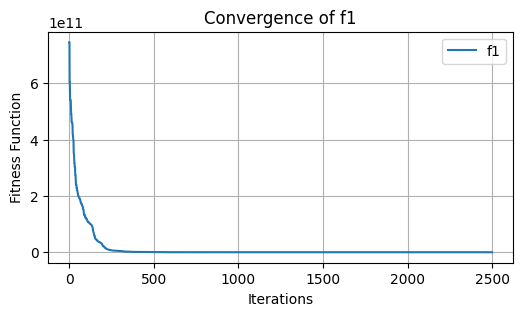

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)


def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []
        #step_size = 0.1  # Initial step size for Levy flight

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''
def f1(x, rotation=None, shift=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]
    if rotation is None:
        rotation = rotations[nx][0]
    if shift is None:
        shift = shifts[0][:nx]
    x_transformed = shift_rotate(x, shift, rotation)
    return bent_cigar(x_transformed) + 100.0


# Define the list of objective functions
objective_functions = [ f1 ]


N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

print("\nBest Fitness Value for Each Iteration")
print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f1')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


function 2

Streaming output truncated to the last 5000 lines.
| Function   | Iteration      |   Best Fitness |
+============+================+================+
| f2         | Iteration 1    |     1.0849E+48 |
+------------+----------------+----------------+
| f2         | Iteration 2    |     7.1672E+46 |
+------------+----------------+----------------+
| f2         | Iteration 3    |     2.9271E+45 |
+------------+----------------+----------------+
| f2         | Iteration 4    |     2.9271E+45 |
+------------+----------------+----------------+
| f2         | Iteration 5    |     2.9271E+45 |
+------------+----------------+----------------+
| f2         | Iteration 6    |     3.7143E+43 |
+------------+----------------+----------------+
| f2         | Iteration 7    |     1.0291E+41 |
+------------+----------------+----------------+
| f2         | Iteration 8    |     1.0291E+41 |
+------------+----------------+----------------+
| f2         | Iteration 9    |     1.0291E+41 |
+------------+----

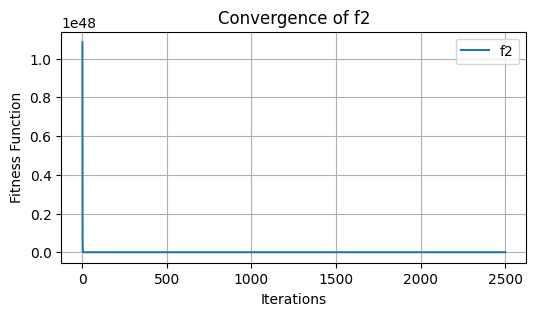

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)


def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')


    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []
        #step_size = 0.1  # Initial step size for Levy flight

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time



    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''
def f2(x, rotation=None, shift=None):
    if 'warned' not in f2.__dict__:
        f2.warned = True
        print('WARNING: f2 has been deprecated from the CEC 2017 benchmark suite')
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]
    if rotation is None:
        rotation = rotations[nx][1]
    if shift is None:
        shift = shifts[1][:nx]
    x_transformed = shift_rotate(x, shift, rotation)
    return sum_diff_pow(x_transformed) + 200.0


# Define the list of objective functions
objective_functions = [ f2 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables

results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f2')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


## Function 3

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f3         |      8.5695E+03 |       1.3938E+05 |     3.6777E+04 |           2.3441E+04 |       3.1342E+04 |       9.1302E+02 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


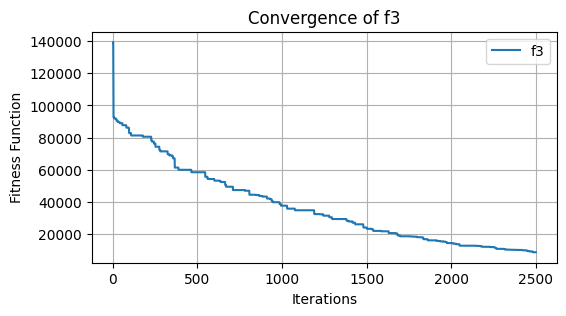

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)


def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''
def f3(x, rotation=None, shift=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][2]
    if shift is None:
        shift = shifts[2][:nx]

    x_transformed = shift_rotate(x, shift, rotation)
    return zakharov(x_transformed) + 300.0



# Define the list of objective functions
objective_functions = [ f3 ]


N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f3')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# Function 4

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f4         |      5.1455E+02 |       2.7135E+04 |     9.2960E+02 |           1.7086E+03 |       5.1618E+02 |       8.3668E+02 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


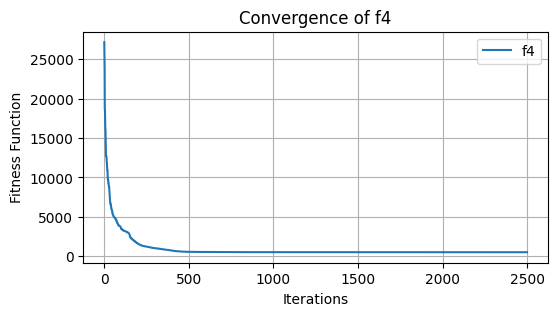

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''

def f4(x, rotation=None, shift=None):
    #Shifted and Rotated Rosenbrock's Function

    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][3]
    if shift is None:
        shift = shifts[3][:nx]
    x_transformed = shift_rotate(x, shift, rotation)
    return rosenbrock(x_transformed) + 400.0


# Define the list of objective functions
objective_functions = [ f4 ]


N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f4')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

# Function 5

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f5         |      7.2110E+02 |       1.0366E+03 |     7.6473E+02 |           4.7308E+01 |       7.5094E+02 |       8.1412E+02 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


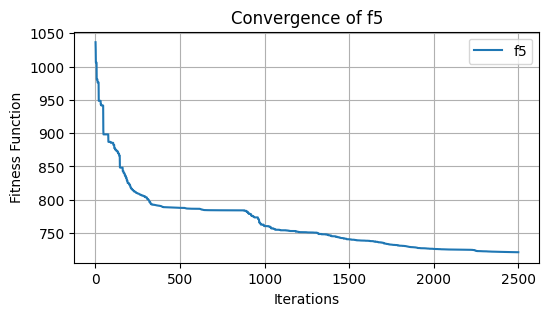

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''


def f5(x, rotation=None, shift=None):

    #Shifted and Rotated Rastrigin's Function

    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][4]
    if shift is None:
        shift = shifts[4][:nx]
    x_transformed = shift_rotate(x, shift, rotation)
    return rastrigin(x_transformed) + 500.0


# Define the list of objective functions
objective_functions = [ f5 ]


N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f5')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

# FUnction 6

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f6         |      6.5434E+02 |       7.5675E+02 |     6.6495E+02 |           1.0333E+01 |       6.6164E+02 |       9.0905E+02 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


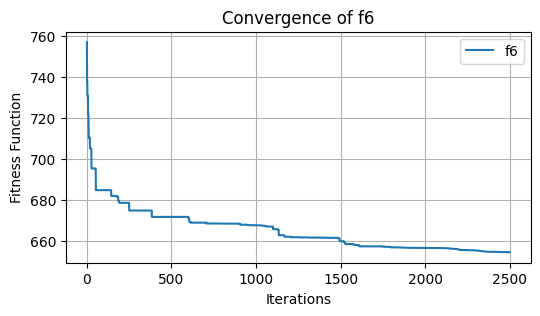

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm



def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''


def f6(x, rotation=None, shift=None):

    #Shifted and Rotated Schaffer's F7 Function

    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][5]
    if shift is None:
        shift = shifts[5][:nx]
    x_transformed = shift_rotate(x, shift, rotation)
    return schaffers_f7(x_transformed) + 600.0


# Define the list of objective functions
objective_functions = [ f6 ]


N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f6')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# Function 7

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f7         |      1.0097E+03 |       1.5952E+03 |     1.0908E+03 |           7.7361E+01 |       1.0728E+03 |       1.2668E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


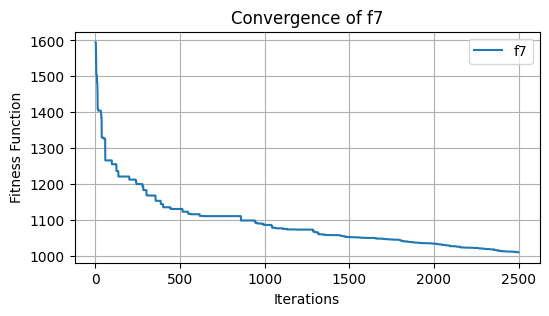

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)



def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''


def f7(x, rotation=None, shift=None):

    #Shifted and Rotated Lunacek Bi-Rastrigin's Function

    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][6]
    if shift is None:
        shift = shifts[6][:nx]
    # pass the shift and rotation directly to the function
    return lunacek_bi_rastrigin(x, shift, rotation) + 700.0



# Define the list of objective functions
objective_functions = [f7]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

# Function 8

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f8         |      9.9103E+02 |       1.2697E+03 |     9.9746E+02 |           2.5556E+01 |       9.9104E+02 |       9.7472E+02 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


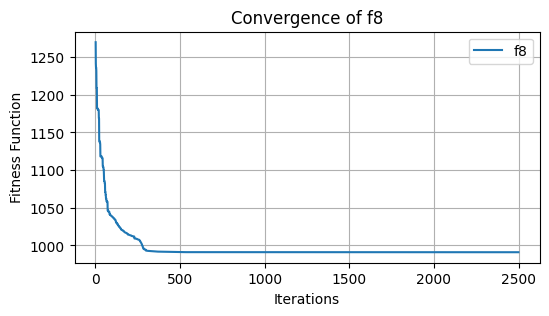

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm



def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''


def f8(x, rotation=None, shift=None):

    #Shifted and Rotated Non-Continuous Rastrigin’s Function
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][7]
    if shift is None:
        shift = shifts[7][:nx]
    # pass the shift and rotation directly to the function
    return non_cont_rastrigin(x, shift, rotation) + 800.0


# Define the list of objective functions
objective_functions = [f8 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f8')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# Function 9

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f9         |      2.2119E+03 |       1.8688E+04 |     3.5156E+03 |           1.7805E+03 |       3.1474E+03 |       1.0551E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


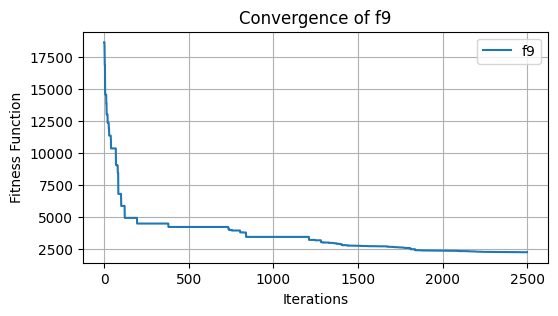

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py



def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3



def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''


def f9(x, rotation=None, shift=None):

    #Shifted and Rotated Levy Function
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][8]
    if shift is None:
        shift = shifts[8][:nx]
    x_transformed = shift_rotate(x, shift, rotation)
    return levy(x_transformed) + 900.0


# Define the list of objective functions
objective_functions = [f9 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f9')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# Function 10

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f10        |      5.0872E+03 |       1.0852E+04 |     5.3651E+03 |           8.0655E+02 |       5.0882E+03 |       1.1724E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


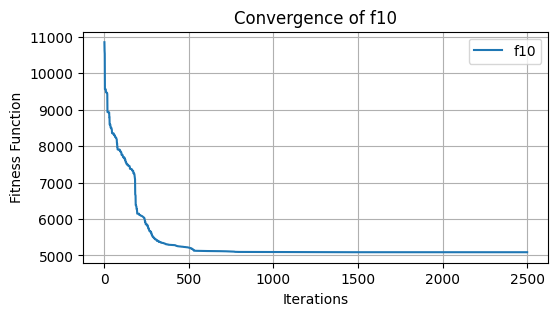

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''


def f10(x, rotation=None, shift=None):

    #Shifted and Rotated Schwefel’s Function

    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = rotations[nx][9]
    if shift is None:
        shift = shifts[9][:nx]
    x_transformed = shift_rotate(x, shift, rotation)
    return modified_schwefel(x_transformed) + 1000.0



# Define the list of objective functions
objective_functions = [f10 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f10')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

# **Convergence of function 11 to function 20**

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f11        |      1.1000E+03 |       1.1053E+03 |     1.1000E+03 |           1.0683E-01 |       1.1000E+03 |       1.3239E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


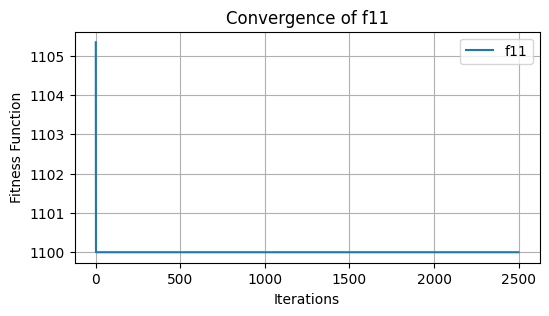

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py


def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''

def f11(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.2, 0.4, 0.4])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    return y + 1100.0


# Define the list of objective functions
objective_functions = [ f11 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f11')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f12        |      1.2000E+03 |       1.2103E+03 |     1.2000E+03 |           2.0568E-01 |       1.2000E+03 |       9.0156E+02 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


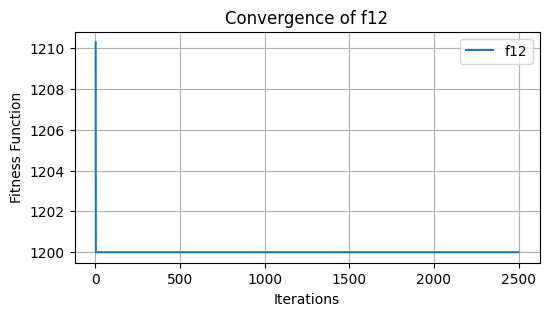

In [2]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2011

'''Unimodal Functions:'''


def f12(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.3, 0.3, 0.4])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    return y + 1200.0


# Define the list of objective functions
objective_functions = [f12 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f12')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

# Function 13

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f13        |      1.3000E+03 |       1.3107E+03 |     1.3000E+03 |           2.1390E-01 |       1.3000E+03 |       1.3240E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


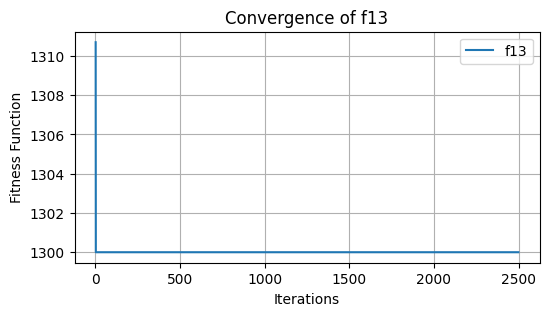

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017

'''Unimodal Functions:'''

def f13(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.3, 0.3, 0.4])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    return y + 1300.0



# Define the list of objective functions
objective_functions = [ f13 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f13')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# Function 14

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f14        |      1.4000E+03 |       1.4098E+03 |     1.4000E+03 |           1.9507E-01 |       1.4000E+03 |       1.3972E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


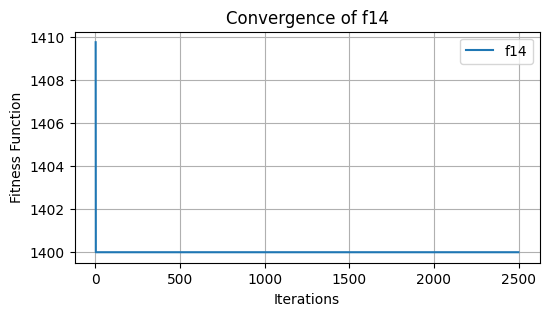

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py


def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017

'''Unimodal Functions:'''



def f14(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.2, 0.2, 0.2, 0.4])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    y += np.sum(np.square(x_parts[3]))  # Placeholder function
    return y + 1400.0



# Define the list of objective functions
objective_functions = [f14 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f14')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

# Function 15

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f15        |      1.5000E+03 |       1.5042E+03 |     1.5000E+03 |           8.3638E-02 |       1.5000E+03 |       1.3965E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


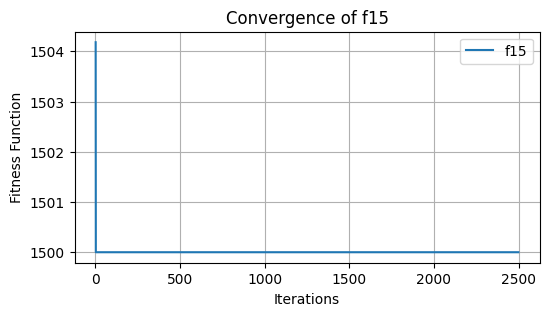

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py


def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017

'''Unimodal Functions:'''


def f15(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.2, 0.2, 0.3, 0.3])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    y += np.sum(np.square(x_parts[3]))  # Placeholder function
    return y + 1500.0

# Define the list of objective functions
objective_functions = [ f15 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f15')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f16        |      1.6000E+03 |       1.6102E+03 |     1.6000E+03 |           2.0336E-01 |       1.6000E+03 |       1.3844E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


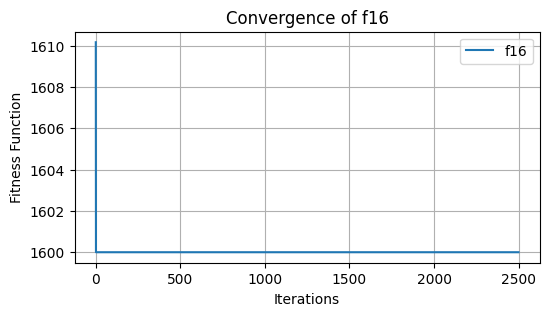

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py


def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017

'''Unimodal Functions:'''



def f16(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.2, 0.2, 0.3, 0.3])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    y += np.sum(np.square(x_parts[3]))  # Placeholder function
    return y + 1600.0



# Define the list of objective functions
objective_functions = [ f16 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Assuming you've generated table_data_fitness as in your previous code

# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f16')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# function 17

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f17        |      1.7000E+03 |       1.7067E+03 |     1.7000E+03 |           1.3415E-01 |       1.7000E+03 |       1.0172E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


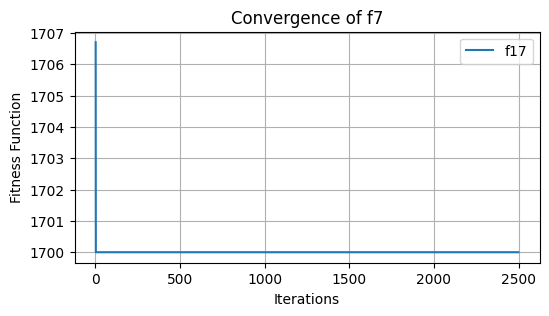

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py

def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017

'''Unimodal Functions:'''


def f17(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.1, 0.2, 0.2, 0.2, 0.3])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    y += np.sum(np.square(x_parts[3]))  # Placeholder function
    y += np.sum(np.square(x_parts[4]))  # Placeholder function
    return y + 1700.0


# Define the list of objective functions
objective_functions = [f17 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# Function 18

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f18        |      1.8000E+03 |       1.8060E+03 |     1.8000E+03 |           1.1942E-01 |       1.8000E+03 |       1.0165E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


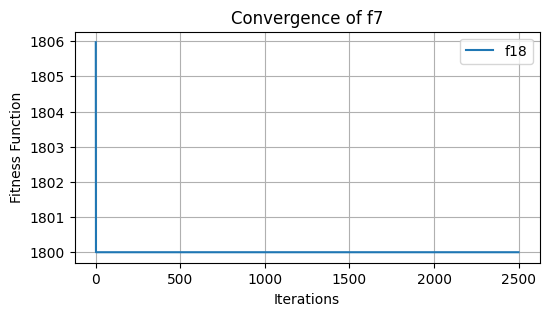

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017

'''Unimodal Functions:'''


def f18(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.2, 0.2, 0.2, 0.2, 0.2])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    y += np.sum(np.square(x_parts[3]))  # Placeholder function
    y += np.sum(np.square(x_parts[4]))  # Placeholder function
    return y + 1800.0



# Define the list of objective functions
objective_functions = [ f18 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

# Function 19

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f19        |      1.9000E+03 |       1.9098E+03 |     1.9000E+03 |           1.9633E-01 |       1.9000E+03 |       1.0079E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


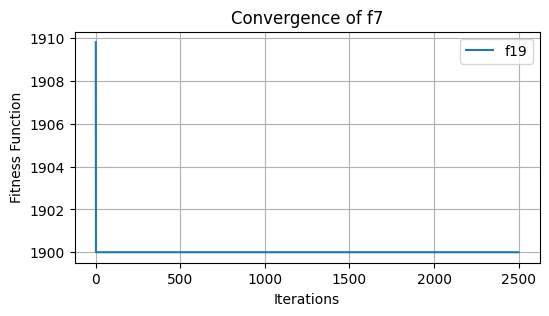

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def f19(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.2, 0.2, 0.2, 0.2, 0.2])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    y += np.sum(np.square(x_parts[3]))  # Placeholder function
    y += np.sum(np.square(x_parts[4]))  # Placeholder function
    return y + 1900.0



# Define the list of objective functions
objective_functions = [ f19 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# Function 20

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f20        |      2.0000E+03 |       2.0020E+03 |     2.0000E+03 |           4.0666E-02 |       2.0000E+03 |       1.0583E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


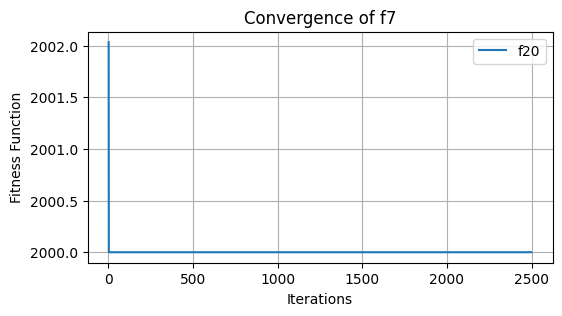

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017

'''Unimodal Functions:'''



def f20(x, rotation=None, shift=None, shuffle=None):
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotation is None:
        rotation = np.eye(nx)  # Default to identity matrix
    if shift is None:
        shift = np.zeros(nx)  # Default to zero shift
    if shuffle is None:
        shuffle = np.arange(nx)  # Default shuffle

    x_transformed = shift_rotate(x, shift, rotation)
    x_parts = shuffle_and_partition(x_transformed, shuffle, [0.1, 0.1, 0.2, 0.2, 0.2, 0.2])

    y = np.sum(np.square(x_parts[0]))  # Placeholder function
    y += np.sum(np.square(x_parts[1]))  # Placeholder function
    y += np.sum(np.square(x_parts[2]))  # Placeholder function
    y += np.sum(np.square(x_parts[3]))  # Placeholder function
    y += np.sum(np.square(x_parts[4]))  # Placeholder function
    y += np.sum(np.square(x_parts[5]))  # Placeholder function
    return y + 2000.0


# Define the list of objective functions
objective_functions = [ f20 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f21        |      2.2463E+03 |       2.5087E+03 |     2.2531E+03 |           1.2426E+01 |       2.2519E+03 |       1.7462E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


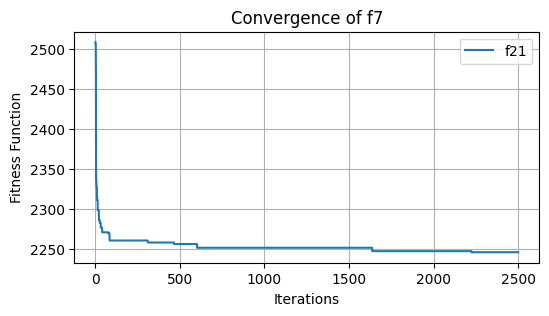

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )


def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f21(x, rotations=None, shifts=None):
    """
    Composition Function 1 (N=3)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(3, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(3, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum((x - 1) ** 2, axis=1),  # Rosenbrock function
        lambda x: np.sum(100 * (x ** 2), axis=1),  # High Conditioned Elliptic function
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1)  # Rastrigin function
    ]
    sigmas = np.array([10.0, 20.0, 30.0])
    lambdas = np.array([1.0, 1.0e-6, 1.0])
    biases = np.array([0.0, 100.0, 200.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2100


# Define the list of objective functions
objective_functions = [ f21 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f22        |      2.3812E+03 |       2.5964E+03 |     2.3860E+03 |           1.2142E+01 |       2.3812E+03 |       1.7792E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


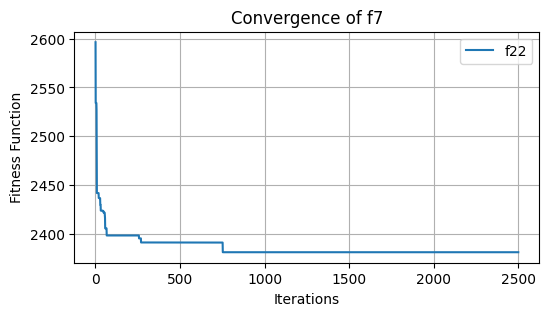

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f22(x, rotations=None, shifts=None):
    """
    Composition Function 2 (N=3)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(3, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(3, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1),  # Rastrigin function
        lambda x: np.sum(x ** 2 / 4000 - np.cos(x) + 1, axis=1),  # Griewank function
        lambda x: np.sum(np.abs(x) + np.abs(np.sin(x)), axis=1)  # Modified Schwefel function
    ]
    sigmas = np.array([10.0, 20.0, 30.0])
    lambdas = np.array([1.0, 10.0, 1.0])
    biases = np.array([0.0, 100.0, 200.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2200



# Define the list of objective functions
objective_functions = [ f22 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f23        |      2.4945E+03 |       2.6994E+03 |     2.5040E+03 |           9.1783E+00 |       2.5065E+03 |       2.2548E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


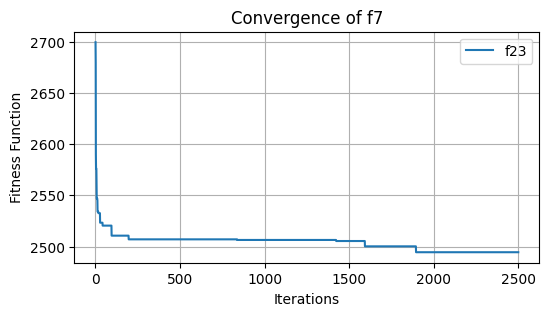

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f23(x, rotations=None, shifts=None):
    """
    Composition Function 3 (N=4)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(4, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(4, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum((x - 1) ** 2, axis=1),  # Rosenbrock function
        #lambda x: np.sum(-20 * np.exp(-0.2 * np.sqrt(1 / nx * np.sum(x ** 2, axis=1))) - np.exp(1 / nx * np.sum(np.cos(2 * np.pi * x), axis=1)) + 20 + np.exp(1), axis=1),  # Ackley function
        ackley,
        lambda x: np.sum(x ** 2 / 4000 - np.cos(x) + 1, axis=1),  # Modified Schwefel function
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1)  # Rastrigin function
    ]
    sigmas = np.array([10.0, 20.0, 30.0, 40.0])
    lambdas = np.array([1.0, 10.0, 1.0, 1.0])
    biases = np.array([0.0, 100.0, 200.0, 300.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2300



# Define the list of objective functions
objective_functions = [ f23 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f24        |      2.5821E+03 |       2.7738E+03 |     2.5850E+03 |           1.1249E+01 |       2.5821E+03 |       2.0732E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


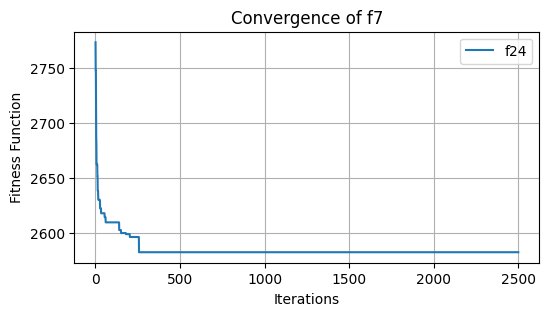

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f24(x, rotations=None, shifts=None):
    """
    Composition Function 4 (N=4)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(4, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(4, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum(np.cos(x), axis=1),  # Ackley function
        lambda x: np.sum((x - 1) ** 2, axis=1),  # High Conditioned Elliptic function
        lambda x: np.sum(x ** 2 / 4000 - np.cos(x) + 1, axis=1),  # Griewank function
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1)  # Rastrigin function
    ]
    sigmas = np.array([10.0, 20.0, 30.0, 40.0])
    lambdas = np.array([1.0, 1.0e-6, 10.0, 1.0])
    biases = np.array([0.0, 100.0, 200.0, 300.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2400


# Define the list of objective functions
objective_functions = [ f24 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


# function  25

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f25        |      3.0251E+03 |       3.7214E+03 |     3.0376E+03 |           4.2424E+01 |       3.0251E+03 |       2.4052E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


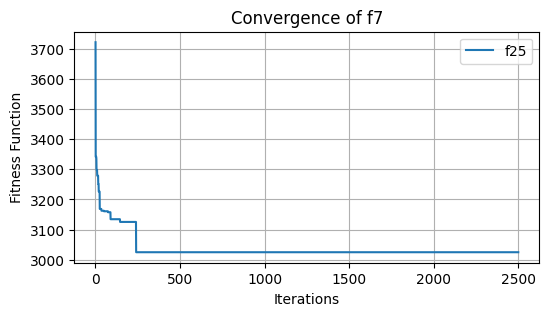

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f25(x, rotations=None, shifts=None):
    """
    Composition Function 5 (N=5)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(5, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(5, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1),  # Rastrigin function
        lambda x: np.sum(np.abs(x) + np.abs(np.sin(x)), axis=1),  # Happy Cat function
        lambda x: np.sum(np.cos(x), axis=1),  # Ackley function
        lambda x: np.sum(x ** 2 / 4000 - np.cos(x) + 1, axis=1),  # Discus function
        lambda x: np.sum((x - 1) ** 2, axis=1)  # Rosenbrock function
    ]
    sigmas = np.array([10.0, 20.0, 30.0, 40.0, 50.0])
    lambdas = np.array([10.0, 1.0, 10.0, 1.0e-6, 1.0])
    biases = np.array([0.0, 100.0, 200.0, 300.0, 400.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2500




# Define the list of objective functions
objective_functions = [ f25 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f26        |      2.8103E+03 |       3.5962E+03 |     2.8178E+03 |           2.0761E+01 |       2.8103E+03 |       2.3251E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


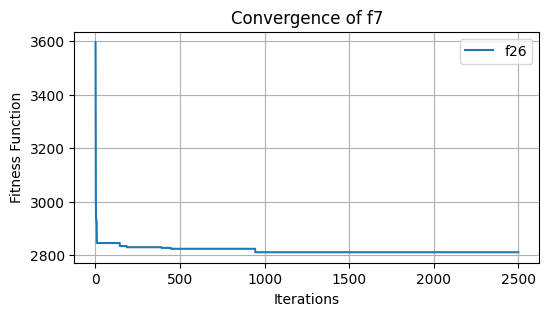

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f26(x, rotations=None, shifts=None):
    """
    Composition Function 6 (N=5)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(5, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(5, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum(np.exp(-x ** 2), axis=1),  # Expanded Schaffer's F6 function
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1),  # Modified Schwefel function
        lambda x: np.sum(np.cos(x), axis=1),  # Griewank function
        lambda x: np.sum(np.sin(x) ** 2, axis=1),  # Rosenbrock function
        lambda x: np.sum(x ** 2, axis=1)  # Rastrigin function
    ]
    sigmas = np.array([10.0, 20.0, 20.0, 30.0, 40.0])
    lambdas = np.array([5.0e-4, 1.0, 10.0, 1.0, 10.0])
    biases = np.array([0.0, 100.0, 200.0, 300.0, 400.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2600


# Define the list of objective functions
objective_functions = [ f26 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)


Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f27        |      3.2439E+03 |       1.7521E+04 |     3.3071E+03 |           3.7564E+02 |       3.2439E+03 |       4.0249E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


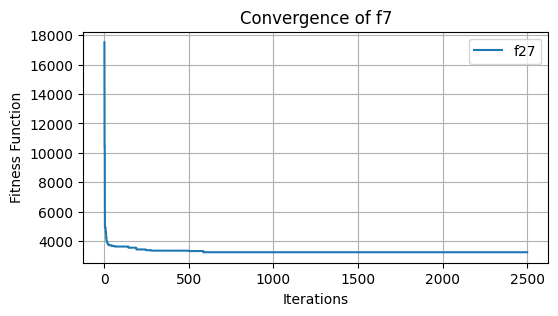

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)




def f27(x, rotations=None, shifts=None):
    """
    Composition Function 7 (N=6)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(6, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(6, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum(x ** 2 + x ** 4, axis=1),  # HGBat function
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1),  # Rastrigin function
        lambda x: np.sum(np.cos(x), axis=1),  # Modified Schwefel function
        lambda x: np.sum(x[:, 1:] ** 2 + 10 * x[:, :-1] ** 2, axis=1),  # Bent Cigar function
        lambda x: np.sum(1e6 * x ** 2, axis=1),  # High Conditioned Elliptic function
        lambda x: np.sum(np.exp(-x ** 2), axis=1),  # Expanded Schaffer's F6 function
    ]
    sigmas = np.array([10.0, 20.0, 30.0, 40.0, 50.0, 60.0])
    lambdas = np.array([10.0, 10.0, 2.5, 1.0e-26, 1.0e-6, 5.0e-4])
    biases = np.array([0.0, 100.0, 200.0, 300.0, 400.0, 500.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2700

# Define the list of objective functions
objective_functions = [ f27 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f28        |      3.0481E+03 |       3.1665E+03 |     3.0537E+03 |           8.5700E+00 |       3.0518E+03 |       4.0114E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


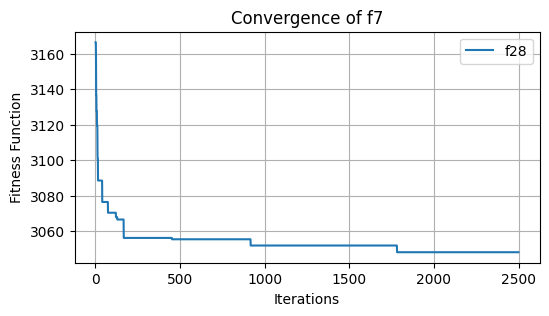

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f28(x, rotations=None, shifts=None):
    """
    Composition Function 8 (N=6)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50 or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(6, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(6, nx)  # Assuming random shifts for illustration

    funcs = [
        lambda x: np.sum(np.exp(-x ** 2), axis=1),  # Expanded Schaffer's F6 function
        lambda x: np.sum(np.cos(x), axis=1),  # Griewank function
        lambda x: np.sum(x ** 2, axis=1),  # Discus function
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1),  # Rosenbrock function
        lambda x: np.sum(np.abs(x) + np.abs(np.sin(x)), axis=1),  # Happy Cat function
        lambda x: np.sum(x ** 2 - 10 * np.cos(2 * np.pi * x) + 10, axis=1),  # Expanded Schaffer's F6 function
    ]
    sigmas = np.array([10.0, 20.0, 30.0, 40.0, 50.0, 60.0])
    lambdas = np.array([10.0, 10.0, 1.0e-6, 1.0, 1.0, 5.0e-4])
    biases = np.array([0.0, 100.0, 200.0, 300.0, 400.0, 500.0])

    return _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases) + 2800


# Define the list of objective functions
objective_functions = [ f28 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f29        |      1.4018E+03 |       1.4066E+03 |     1.4018E+03 |           1.0578E-01 |       1.4018E+03 |       2.4607E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


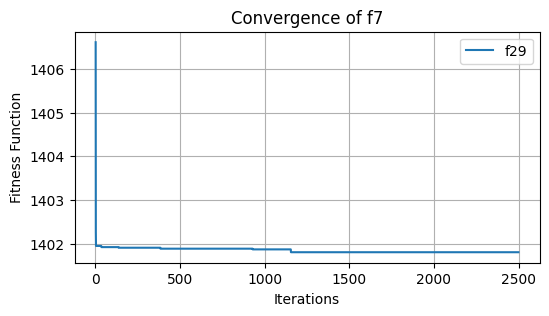

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )

def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)



def f29(x, rotations=None, shifts=None, shuffles=None):
    """
    Composition Function 9 (N=3)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50, or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
        shuffles (array): Optional shuffle vectors (NxD). If None (default), the
            official permutation vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(3, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(3, nx)  # Assuming random shifts for illustration
    if shuffles is None:
        # Provide default shuffles for different dimensions (NxM)
        # Example:
        shuffles = np.random.permutation(np.eye(nx))  # Assuming random shuffling for illustration

    funcs = [
        #lambda x: np.sum(x ** 2, axis=1),  # Hybrid Function 15
        #lambda x: np.sum((x - 0.5) ** 2, axis=1),  # Hybrid Function 16
        #lambda x: np.sum(np.sin(5 * np.pi * x) ** 6, axis=1)  # Hybrid Function 17
        lambda x, rotation=None, shift=None, shuffle=None: np.sum(x ** 2, axis=1),  # Hybrid Function 15
        lambda x, rotation=None, shift=None, shuffle=None: np.sum((x - 0.5) ** 2, axis=1),  # Hybrid Function 16
        lambda x, rotation=None, shift=None, shuffle=None: np.sum(np.sin(5 * np.pi * x) ** 6, axis=1)  # Hybrid Function 17
    ]
    sigmas = np.array([10.0, 30.0, 50.0])
    biases = np.array([0.0, 100.0, 200.0])
    offsets = np.array([1500, 1600, 1700])  # Subtract F* added at the end of the functions

    return _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases) + 2900


# Define the list of objective functions
objective_functions = [ f29 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)

Standard STO algorithm for CEC2011(f1-f10) benchmark test function
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+
| Function   |   Best Solution |   Worst Solution |   Mean Fitness |   Standard Deviation |   Median Fitness |   Execution Time |
+============+=================+==================+================+======================+==================+==================+
| f30        |      1.3052E+03 |       1.3052E+03 |     1.3052E+03 |           0.0000E+00 |       1.3052E+03 |       2.4372E+03 |
+------------+-----------------+------------------+----------------+----------------------+------------------+------------------+


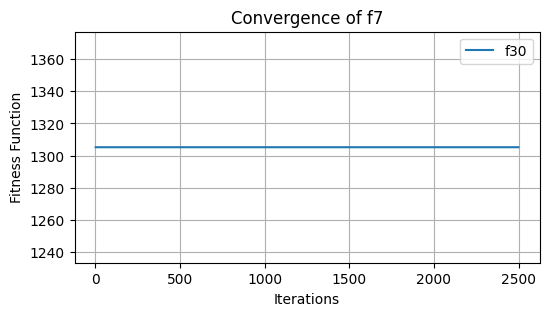

In [ ]:
import numpy as np
import math
import time
from tabulate import tabulate
import os
import sys
import pickle
from typing import Optional
import matplotlib.pyplot as plt
import csv


# Content from transforms.py

file_path = '/content/drive/My Drive/Colab Notebooks/data.pkl'
with open(file_path, 'rb') as _pkl_file:
    _pkl = pickle.load(_pkl_file)

rotations = {
    2: _pkl['M_D2'],
    10: _pkl['M_D10'],
    20: _pkl['M_D20'],
    30: _pkl['M_D30'],
    50: _pkl['M_D50'],
    100: _pkl['M_D100']

}

rotations_cf = {
    2: _pkl['M_cf_d2'],
    10: _pkl['M_cf_D10'],
    20: _pkl['M_cf_D20'],
    30: _pkl['M_cf_D30'],
    50: _pkl['M_cf_D50'],
    100: _pkl['M_cf_D100']

}

# Shape (20, 100)
# Contains 100-dimension shift vectors for functions f1 to f20
shifts = _pkl['shift']

# Shape (10, 10, 100)
# Contains 10 100-dimension shift vectors for functions f21 to f30
shifts_cf = _pkl['shift_cf']

# Each has shape (10, N) containing N-dimensional permutations for functions f11
# to f20 (note: the original were 1-indexed, these are 0-indexed)
shuffles = {
    10: _pkl['shuffle_D10'],
    30: _pkl['shuffle_D30'],
    50: _pkl['shuffle_D50'],
    100: _pkl['shuffle_D100']
}

# Each has shape (2, 10, N) containing 10 N-dimensional permutations for
# functions f29 and f30 (note: the original were 1-indexed, these are 0-indexed)
shuffles_cf = {
    10: _pkl['shuffle_cf_D10'],
    30: _pkl['shuffle_cf_D30'],
    50: _pkl['shuffle_cf_D50'],
    100: _pkl['shuffle_cf_D100']
}

def shift_rotate(x: np.ndarray, shift: np.ndarray, rotation: np.ndarray) -> np.ndarray:
    shifted = np.expand_dims(x - np.expand_dims(shift, 0), -1)
    x_transformed = np.matmul(np.expand_dims(rotation, 0), shifted)
    return x_transformed[:, :, 0]

def shuffle_and_partition(x, shuffle, partitions):
    nx = x.shape[1]
    xs = np.zeros_like(x)
    for i in range(0, nx):
        xs[:, i] = x[:, shuffle[i]]
    parts = []
    start, end = 0, 0
    for p in partitions[:-1]:
        end = start + int(np.ceil(p * nx))
        parts.append(xs[:, start:end])
        start = end
    parts.append(xs[:, end:])
    return parts

# Content from basic.py
def bent_cigar(x: np.ndarray) -> np.ndarray:
    sm = np.sum(x[:, 1:] * x[:, 1:], axis=1)
    sm = sm * 10e6
    return x[:, 0]*x[:, 0] + sm

def sum_diff_pow(x: np.ndarray) -> np.ndarray:
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    x_pow = np.power(np.abs(x), i)
    return np.sum(x_pow, axis=1)

def zakharov(x: np.ndarray) -> np.ndarray:
    # NOTE: the i+1 term is not in the CEC function definitions, but is in the
    # code and in any definition you find online
    i = np.expand_dims(np.arange(x.shape[1]) + 1, 0)
    sm = np.sum(i * x, axis=1)
    sms = np.sum(x * x, axis=1)
    sm = 0.5 * sm
    sm = sm * sm
    return sms + sm + (sm * sm)

def rosenbrock(x: np.ndarray) -> np.ndarray:
    x = 0.02048 * x + 1.0
    t1 = x[:, :-1] * x[:, :-1] - x[:, 1:]
    t1 = 100 * t1 * t1
    t2 = x[:, :-1] - 1
    t2 = t2 * t2
    return np.sum(t1 + t2, axis=1)


def rastrigin(x: np.ndarray) -> np.ndarray:
    # NOTE: the 0.0512 shrinking is omitted in the problem definitions but is
    # present in the provided code
    x = 0.0512 * x
    cs = np.cos(2 * np.pi * x)
    xs = x*x - 10*cs + 10
    return np.sum(xs, axis=1)


def expanded_schaffers_f6(x: np.ndarray) -> np.ndarray:
    t = x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:]
    t1 = np.sin(np.sqrt(t))
    t1 = t1*t1 - 0.5
    t2 = 1 + 0.001*t
    t2 = t2*t2
    return np.sum(0.5 + t1/t2, axis=1)


def lunacek_bi_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)

    # calculate the coefficients
    mu0 = 2.5
    s = 1 - 1 / (2 * ((nx+20)**0.5) - 8.2)
    mu1 = -((mu0*mu0-1)/s)**0.5

    # shift and scale
    y = 0.1 * (x - shift)

    tmpx = 2 * y
    tmpx[:, shift[0] < 0] *= -1

    z = tmpx.copy()
    tmpx = tmpx + mu0

    t1 = tmpx - mu0
    t1 = t1 * t1
    t1 = np.sum(t1, axis=1)
    t2 = tmpx - mu1
    t2 = s * t2 * t2
    t2 = np.sum(t2, axis=1) + nx

    if rotation is None:
        y = z
    else:
        y = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    y = np.cos(2.0*np.pi*y)
    t = np.sum(y, axis=1)

    r = t1
    r[t1 >= t2] = t2[t1 >= t2]
    return r + 10.0*(nx-t)


def non_cont_rastrigin(
    x: np.ndarray,
    shift: Optional[np.ndarray] = None,
    rotation: Optional[np.ndarray] = None,
) -> np.ndarray:
    # a special case; we need the shift vector and rotation matrix
    nx = x.shape[1]
    if shift is None:
        shift = np.zeros((1, nx))
    else:
        shift = np.expand_dims(shift, 0)
    shifted = x - shift

    sm = 0.0
    x = x.copy()
    mask = np.abs(shifted) > 0.5
    x[mask] = (shift + np.floor(2*shifted+0.5) * 0.5)[mask]

    # for i in range(0, nx):
    #     if abs(x[i]-shift[i]) > 0.5:
    #         x[i] = shift[i] + np.floor(2*(x[i]-shift[i])+0.5)/2

    z = 0.0512 * shifted
    if rotation is not None:
        z = np.matmul(
            np.expand_dims(rotation, 0),
            np.expand_dims(z, -1),
        )[:, :, 0]

    sm = z*z - 10*np.cos(2*np.pi*z) + 10
    sm = np.sum(sm, axis=1)
    # for i in range(0, nx):
    #     sm += (z[i]*z[i] - 10.0*np.cos(2.0*np.pi*z[i]) + 10.0)
    return sm


def levy(x: np.ndarray) -> np.ndarray:
    # NOTE: the function definitions state to scale by 5.12/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.0512 * x
    w = 1.0 + 0.25*(x - 1.0)

    term1 = (np.sin(np.pi*w[:, 0]))**2
    term3 = ((w[:, -1] - 1)**2) * (1 + ((np.sin(2*np.pi*w[:, -1]))**2))

    sm = 0.0

    wi = w[:, :-1]
    newv = ((wi - 1)**2) * (1 + 10*((np.sin(np.pi*wi+1))**2))
    sm = np.sum(newv, axis=1)

    return term1 + sm + term3


def modified_schwefel(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 10.0 * x # scale to search range

    z = x + 420.9687462275036
    mask1 = z < -500
    mask2 = z > 500
    sm = z * np.sin(np.sqrt(np.abs(z)))

    zm = np.mod(np.abs(z), 500)
    zm[mask1] = (zm[mask1] - 500)
    zm[mask2] = (500 - zm[mask2])
    t = z + 500
    t[mask2] = z[mask2] - 500
    t = t*t

    mask1_or_2 = np.logical_or(mask1, mask2)
    sm[mask1_or_2] = (zm * np.sin(np.sqrt(np.abs(zm))) - t / (10_000*nx))[mask1_or_2]
    return 418.9829*nx - np.sum(sm, axis=1)


def high_conditioned_elliptic(x: np.ndarray) -> np.ndarray:
    factor = 6 / (x.shape[1] - 1)
    i = np.expand_dims(np.arange(x.shape[1]), 0)
    sm = x*x * 10**(i * factor)
    return np.sum(sm, axis=1)


def discus(x: np.ndarray) -> np.ndarray:
    sm0 = 1e+6*x[:, 0]*x[:, 0]
    sm = np.sum(x[:, 1:]*x[:, 1:], axis=1)
    return sm0 + sm


def ackley(x: np.ndarray) -> np.ndarray:
    smsq = np.sum(x*x, axis=1)
    smcs = np.sum(np.cos((2*np.pi)*x), axis=1)
    inx = 1/x.shape[1]
    return -20*np.exp(-0.2*np.sqrt(inx*smsq)) - np.exp(inx*smcs) + 20 + np.e


def weierstrass(x: np.ndarray) -> np.ndarray:
    x = 0.005 * x
    k = np.arange(start=0, stop=21, step=1)
    k = np.expand_dims(np.expand_dims(k, 0), 0)
    ak = 0.5**k
    bk = np.pi * (3**k)

    kcs = ak * np.cos(2*(np.expand_dims(x, -1) + 0.5)*bk)  # shape (M, nx, 21)
    ksm = np.sum(kcs, axis=2)
    sm = np.sum(ksm, axis=1)

    kcs = ak * np.cos(bk)
    ksm = np.sum(kcs)
    return sm - x.shape[1]*ksm


def griewank(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    x = 6.0 * x
    factor = 1/4000
    d = np.expand_dims(np.arange(start=1, stop=nx + 1), 0)
    cs = np.cos(x / d)
    sm = np.sum(factor*x*x, axis=1)
    pd = np.prod(np.cos(x / d), axis=1)
    return sm - pd + 1


def katsuura(x: np.ndarray) -> np.ndarray:
    x = 0.05 * x
    nx = x.shape[1]
    pw = 10/(nx**1.2)
    prd = 1.0
    tj = 2**np.arange(start=1, stop=33, step=1)
    tj = np.expand_dims(np.expand_dims(tj, 0), 0)
    tjx = tj*np.expand_dims(x, -1)  # shape (M, nx, 32)
    t = np.abs(tjx - np.round(tjx)) / tj
    tsm = np.sum(t, axis=2)

    i = np.arange(nx) + 1
    prd = np.prod((1 + i*tsm)**pw, axis=1)
    df = 10/(nx*nx)
    return df*prd - df


def happy_cat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq - nx))**0.25 + (0.5*smsq + sm)/nx + 0.5


def h_g_bat(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) - 1
    nx = x.shape[1]
    sm = np.sum(x, axis=1)
    smsq = np.sum(x*x, axis=1)
    return (np.abs(smsq*smsq - sm*sm))**0.5 + (0.5*smsq + sm)/nx + 0.5


def expanded_griewanks_plus_rosenbrock(x: np.ndarray) -> np.ndarray:
    x = (0.05 * x) + 1

    tmp1 = x[:, :-1]*x[:, :-1] - x[:, 1:]
    tmp2 = x[:, :-1] - 1.0
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = (temp*temp)/4000 - np.cos(temp) + 1

    tmp1 = x[:, -1:]*x[:, -1:] - x[:, 0:1]
    tmp2 = x[:, -1:] - 1
    temp = 100*tmp1*tmp1 + tmp2*tmp2
    sm = sm + (temp*temp)/4000 - np.cos(temp) + 1

    return np.sum(sm, axis=1)


def schaffers_f7(x: np.ndarray) -> np.ndarray:
    nx = x.shape[1]
    # NOTE: the function definitions state to scale by 0.5/100, but the code
    # doesn't do this, and the example graph in the definitions correspond to
    # the version without scaling
    # x = 0.005 * x
    sm = 0.0
    si = np.sqrt(x[:, :-1]*x[:, :-1] + x[:, 1:]*x[:, 1:])
    tmp = np.sin(50*(np.power(si, 0.2)))
    # NOTE: the original code has this error here (tmp shouldn't be squared)
    # that I'm keeping for consistency.
    sm = np.sqrt(si) * (tmp*tmp + 1)
    sm = np.sum(sm, axis=1)
    sm = (sm*sm) / (nx*nx - 2*nx + 1)
    return sm

def initialize_population(N, num_variables, lb, ub):
    return lb + (ub - lb) * np.random.rand(N, num_variables)

def evaluate_objective(population, objective_function):
    return np.array([objective_function(x) for x in population])

def greedy_selection(new_sol, sol, fitness, objective_function):
    new_fitness = objective_function(new_sol)
    return (
        new_sol if new_fitness < fitness else sol,
        new_fitness if new_fitness < fitness else fitness
    )
def levy_flight(dim, step_size):
    beta = 1.5  # You can experiment with different values for beta
    sigma = (np.math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (np.math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / (abs(v) ** (1 / beta))
    return step_size * step

def sto_algorithm_single(N, MFEs, lb, ub, objective_function):
    num_variables = len(lb)
    T = (MFEs - N) // (4 * N)
    best_solutions = []
    best_fitness_values = []
    execution_time = 0
    best_solution = float('inf')
    worst_solution = float('-inf')

    total_runs = 30
    iterations_per_run = T   # Calculate iterations per run
    for _ in range(total_runs):
        start_time = time.time()

        population = initialize_population(N, num_variables, lb, ub)
        fitness = evaluate_objective(population, objective_function)
        step_size = 0.01  # Initial step size for Levy flight
        fitness_values_per_iteration = []

        for t in range(iterations_per_run):
            for i in range(N):
                # Phase 1: Prey hunting
                Xbest = population[np.argmin(fitness)]
                PP = population[np.where(fitness < fitness[i])]
                if len(PP) == 0:
                    PP = np.append(PP, Xbest)
                TP = PP[np.random.randint(len(PP))]
                l = np.random.randint(1, 2, size=(1, num_variables))
                #r = np.random.uniform(0, 1, num_variables)
                r = np.random.random(num_variables)
                levy_steps = levy_flight(dim, step_size)

                if np.random.rand() < 0.5:  # Apply Levy flight with a probability
                    P1S1 = (population[i] +  r * (TP - l * Xbest))[0] * levy_steps
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)
                else:
                    P1S1 = (population[i] + r * (TP - l * Xbest))[0]
                    population[i], fitness[i] = greedy_selection(P1S1, population[i], fitness[i], objective_function)

                r = np.random.random(num_variables)
                if np.random.rand() < 0.5:
                    P1S2 = population[i] + ( r * (ub - lb)) / (t + 1) * levy_steps
                    # Ensure solutions stay within bounds
                    population[i] = np.clip(population[i], lb, ub)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)
                else:
                    P1S2 = population[i] + (r * (ub - lb)) / (t + 1)
                    population[i], fitness[i] = greedy_selection(P1S2, population[i], fitness[i], objective_function)

                # Phase 2: Fighting with bear
                k = i
                while i == k:
                    k = np.random.randint(0, N)

                r = np.random.uniform(0, 1, num_variables)
                if fitness[k] < fitness[i]:
                    P2S1 = population[i] +  r * (population[k] - l * population[i])
                else:
                    P2S1 = population[i] +  r * (population[i] - l * population[k])
                population[i], fitness[i] = greedy_selection(P2S1, population[i], fitness[i], objective_function)

                TPi = np.random.uniform(0, 1, num_variables)
                P2S2 = population[i] + ( r * (ub - lb)) / (t + 1)
                population[i], fitness[i] = greedy_selection(P2S2, population[i], fitness[i], objective_function)
                fitness_per_iteration = []

                # Adjust step size for Levy flight (optional)
            step_size *= (t+1)/T  # You can experiment with different decay rates
            if t <= T:
                  fitness_values_per_iteration.append(np.min(fitness))

        best_solutions.append(population[np.argmin(fitness)])
        best_solution = np.min(fitness_values_per_iteration)
        worst_solution = np.max(fitness_values_per_iteration)
        mean_fitness = np.mean(fitness_values_per_iteration)
        std_deviation = np.std(fitness_values_per_iteration)
        median_fitness = np.median(fitness_values_per_iteration)

        end_time = time.time()
        execution_time += end_time - start_time

    #mean_fitness /= 25
    #std_deviation /= 25
    #median_fitness /= 25

    return best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration

def sto_algorithm(N, MFEs, lb, ub, objective_functions):
    results = []

    for func in objective_functions:
        best_solutions, best_fitness_values, execution_time, best_solution, worst_solution, mean_fitness, std_deviation, median_fitness, fitness_values_per_iteration = sto_algorithm_single(N, MFEs, lb, ub, func)

        results.append({
            "Function": func.__name__,
            "Best Solution": best_solution,
            "Worst Solution": worst_solution,
            "Mean Fitness": mean_fitness,
            "Standard Deviation": std_deviation,
            "Median Fitness": median_fitness,
            "Execution Time": execution_time,
            "fitness_values_per_iteration": fitness_values_per_iteration
        })

    return results


# objective functions of CEC2017


def _calc_w(x, sigma):
    nx = x.shape[1]
    w = np.sum(x * x, axis=1)
    nzmask = w != 0
    w[nzmask] = ((1.0 / w) ** 0.5)[nzmask] * np.exp(-w / (2.0 * nx * sigma * sigma))[nzmask]
    w[~nzmask] = float('inf')
    return w

def _composition(x, rotations, shifts, funcs, sigmas, lambdas, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        x_t = x_shifted.dot(rotations[i])  # Assuming rotations is a 2D array
        vals[:, i] = funcs[i](x_t)
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1 / N

    return np.sum(w * (lambdas * vals + biases), axis=1)

def _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases):
    nv = x.shape[0]
    nx = x.shape[1]

    N = len(funcs)
    vals = np.zeros((nv, N))
    w = np.zeros((nv, N))
    for i in range(0, N):
        x_shifted = x - np.expand_dims(shifts[i][:nx], 0)
        vals[:, i] = funcs[i](x, rotation=rotations[i], shift=shifts[i][:nx], shuffle=shuffles[i]) - offsets[i]
        w[:, i] = _calc_w(x_shifted, sigmas[i])
    w_sm = np.sum(w, axis=1)

    nz_mask = w_sm != 0.0
    w[nz_mask, :] /= w_sm[nz_mask, None]
    w[~nz_mask, :] = 1/N

    return np.sum(w * (vals + biases), axis=1)


def f30(x, rotations=None, shifts=None, shuffles=None):
    """
    Composition Function 10 (N=3)

    Args:
        x (array): Input vector of dimension 2, 10, 20, 30, 50, or 100.
        rotations (matrix): Optional rotation matrices (NxDxD). If None
            (default), the official matrices from the benchmark suite will be
            used.
        shifts (array): Optional shift vectors (NxD). If None (default), the
            official vectors from the benchmark suite will be used.
        shuffles (array): Optional shuffle vectors (NxD). If None (default), the
            official permutation vectors from the benchmark suite will be used.
    """
    x = np.atleast_2d(x)
    x = np.array(x)
    nx = x.shape[1]

    if rotations is None:
        # Provide default rotations for different dimensions (NxNxM)
        # Example:
        rotations = np.random.rand(3, nx, nx)  # Assuming random rotations for illustration
    if shifts is None:
        # Provide default shifts for different dimensions (NxM)
        # Example:
        shifts = np.random.rand(3, nx)  # Assuming random shifts for illustration
    if shuffles is None:
        # Provide default shuffles for different dimensions (NxM)
        # Example:
        shuffles = np.random.permutation(np.eye(nx))  # Assuming random shuffling for illustration

    funcs = [
        lambda x, rotation=None, shift=None, shuffle=None: np.sum(x ** 2, axis=1),  # Hybrid Function 15
        lambda x, rotation=None, shift=None, shuffle=None: np.sum((x - 0.5) ** 2, axis=1),  # Hybrid Function 18
        lambda x, rotation=None, shift=None, shuffle=None: np.sum(np.sin(5 * np.pi * x) ** 6, axis=1)  # Hybrid Function 19
    ]
    sigmas = np.array([10.0, 30.0, 50.0])
    biases = np.array([0.0, 100.0, 200.0])
    offsets = np.array([1500, 1800, 1900])  # Subtract F* added at the end of the functions

    return _compose_hybrids(x, rotations, shifts, shuffles, funcs, sigmas, offsets, biases) + 3000

# Define the list of objective functions
objective_functions = [ f30 ]

N = 30
dim = 30
lb = np.array([-100.0] * dim)
ub = np.array([100.0] * dim)
num_variables = len(lb)
MFEs = 10000 * num_variables


results = sto_algorithm(N, MFEs, lb, ub, objective_functions)

# Display results in tabular form
headers = ["Function", "Best Solution", "Worst Solution", "Mean Fitness", "Standard Deviation", "Median Fitness", "Execution Time"]
table_data = [[
    result["Function"],
    f"{result['Best Solution']:.4E}",
    f"{result['Worst Solution']:.4E}",
    f"{result['Mean Fitness']:.4E}",
    f"{result['Standard Deviation']:.4E}",
    f"{result['Median Fitness']:.4E}",
    f"{result['Execution Time']:.4E}",
] for result in results]

print("Standard STO algorithm for CEC2011(f1-f10) benchmark test function")
print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=(".4E", ".4E", ".4E", ".4E", ".4E", ".4E", ".4E")))

# Display fitness values for each iteration in tabular form
headers_fitness = ["Function", "Iteration", "Best Fitness"]
table_data_fitness = []
for result in results:
    fitness_values = result['fitness_values_per_iteration']
    for i, fitness_iter in enumerate(fitness_values):
        best_fitness = np.min(fitness_iter)
        if isinstance(best_fitness, np.ndarray):
            best_fitness = best_fitness.item()
        table_data_fitness.append([
            result["Function"],
            f"Iteration {i+1}",
            f"{best_fitness}"
        ])

#print("\nBest Fitness Value for Each Iteration")
#print(tabulate(table_data_fitness, headers=headers_fitness, tablefmt="grid", floatfmt=".4E"))


# Create a dictionary to store fitness values for each iteration of each function
fitness_data = {}
for row in table_data_fitness:
    func_name, iteration, fitness = row
    iteration_num = int(iteration.split()[1])  # Extracting the iteration number
    if func_name not in fitness_data:
        fitness_data[func_name] = {"Iterations": [], "Fitness Values": []}
    fitness_data[func_name]["Iterations"].append(iteration_num)
    fitness_data[func_name]["Fitness Values"].append(float(fitness))

# Plotting the graph
plt.figure(figsize=(6, 3))
for func_name, data in fitness_data.items():
    plt.plot(data["Iterations"], data["Fitness Values"], label=func_name)

plt.xlabel('Iterations')
plt.ylabel('Fitness Function')
plt.title('Convergence of f7')
plt.legend()
plt.grid(True)
plt.show()

# Save fitness data to CSV files
def save_fitness_data_to_csv(func_name, data):
    directory = '/content/drive/My Drive/Colab Notebooks/data_files30/lfsto_rand30'  # Change this path as needed
    if not os.path.exists(directory):
        os.makedirs(directory)

    filepath = os.path.join(directory, f'{func_name}_lfsto_rand_dim30_data.csv')
    with open(filepath, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Fitness Value'])
        for iteration, fitness_value in zip(data["Iterations"], data["Fitness Values"]):
            writer.writerow([iteration, fitness_value])  # Writing fitness values as individual integers or floats

# Save fitness data for each function
for func_name, data in fitness_data.items():
    save_fitness_data_to_csv(func_name, data)